<a href="https://www.kaggle.com/code/vainero/stock-price-prediction-lstm?scriptVersionId=101805739" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

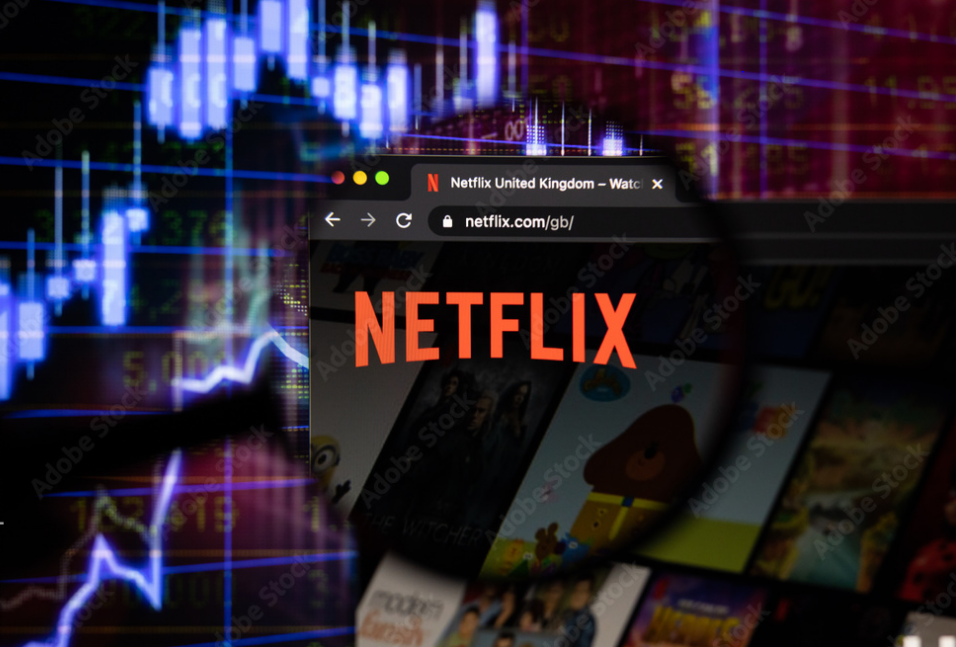

https://stock.adobe.com/

### Content

In this notebook, we will focus on the Long Short-Term Memory (LSTM) layer model in Keras to predict if the stock will go up or down. 

Historical daliy NFLX stock price was collected from Yahoo Finance.

## Import Libraries

In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")  


## Loading Data

In [163]:
data = pd.read_csv('../input/netflix-stock-price-data-set-20022022/NFLX.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200


**Open:** The price of the stock at the beginning of the trading day.

**High:** The highest price of the stock on a trading day.

**Low:** The lowest price of the stock on a trading day.

**Close:** The last price of the stock before the trading day ends.

## Feature Extraction

In [164]:
# Show the number of trading days
print("Total number of traiding days: ",data.shape[0])
print("Total number of fields: ",data.shape[1])

Total number of traiding days:  5044
Total number of fields:  7


In [165]:
# Check the Null and NA values
print("Null values:", data.isnull().values.sum())
print("NA values:", data.isna().values.any())

Null values: 0
NA values: False


We will select from the dataset the **Open** column represents the starting price of the stock for a particular day. 

In [166]:
# Create a new dataframe with only the Open column and convert it into a NumPy array
data = data['Open'].values

# Reshape the data
data = data.reshape(-1, 1) 

In [167]:
# Split the data into training and testing sets
dataset_train = np.array(data[:int(data.shape[0]*0.8)])
dataset_test = np.array(data[int(data.shape[0]*0.8):])

To produce the best-optimized results, we are required to scale the data. 

For this task, we are leveraging scikit-learn library’s **MinMaxScaler()** for converting the input values between 0 to 1.

In [168]:
# Scale the data 
scaler = MinMaxScaler(feature_range=(0,1))

dataset_train = scaler.fit_transform(dataset_train)
dataset_test = scaler.transform(dataset_test)

We will create the helper function with 50 timesteps. In other words, for the features(x) we'll append the last 50 prices, and for the label(y) we'll append the next price.

After that we will convert it into a NumPy array.

In [169]:
# Create the function that will help us to create the datasets
def create_dataset(df):
    x = []
    y = []
    for i in range(50, df.shape[0]):
        x.append(df[i-50:i, 0]) 
        y.append(df[i, 0]) 
    x = np.array(x) 
    y = np.array(y)
    return x,y

In [170]:
# Create the training and testing data by calling our function for each one
x_train, y_train = create_dataset(dataset_train)
x_test, y_test = create_dataset(dataset_test)

In [171]:
# Reshape the data to make it a 3D array in order to use it in LSTM Layer
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

## Building Model

For the LSTM layer, we add **96 units** that represent the dimensionality of the output space. 

The **return_sequences parameter** is set to **True** for returning the last output in output.

For the Dropout layers, we specify the percentage of layers is **20%** that should be dropped. 

The next step is to add the Dense layer. 

In [172]:
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1)) 

In [173]:
# Summary of the model
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 50, 96)            37632     
_________________________________________________________________
dropout_36 (Dropout)         (None, 50, 96)            0         
_________________________________________________________________
lstm_37 (LSTM)               (None, 50, 96)            74112     
_________________________________________________________________
dropout_37 (Dropout)         (None, 50, 96)            0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 50, 96)            74112     
_________________________________________________________________
dropout_38 (Dropout)         (None, 50, 96)            0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 96)               

In [174]:
# Reshape the feature for the LSTM layer 
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) # for expecting 3 dimentions, not 2
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)) 

We will compile the model with the help of **adam** optimizer.

The error is computed using **mean_squared_error**.

In [175]:
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam') 

## Training Model

With our model and data constructed, we can now train the model.

In [176]:
# Define modifiable training hyperparameters.
epochs = 40
batch_size = 64 

# Save the model and start the training
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)
model.save('stock_prediction')

Epoch 1/40
63/63 [==============================] - 6s 13ms/step - loss: 0.0032
Epoch 2/40
63/63 [==============================] - 1s 13ms/step - loss: 7.6460e-04
Epoch 3/40
63/63 [==============================] - 1s 13ms/step - loss: 7.3767e-04
Epoch 4/40
63/63 [==============================] - 1s 14ms/step - loss: 7.9412e-04
Epoch 5/40
63/63 [==============================] - 1s 14ms/step - loss: 6.5825e-04
Epoch 6/40
63/63 [==============================] - 1s 13ms/step - loss: 4.8773e-04
Epoch 7/40
63/63 [==============================] - 1s 13ms/step - loss: 4.5892e-04
Epoch 8/40
63/63 [==============================] - 1s 13ms/step - loss: 4.5860e-04
Epoch 9/40
63/63 [==============================] - 1s 13ms/step - loss: 4.8782e-04
Epoch 10/40
63/63 [==============================] - 1s 13ms/step - loss: 4.9809e-04
Epoch 11/40
63/63 [==============================] - 1s 13ms/step - loss: 4.9584e-04
Epoch 12/40
63/63 [==============================] - 1s 13ms/step - loss: 6.80

In [177]:
# Load the model
model = load_model('stock_prediction')

## Prediction Model

In [178]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1)) 

## Plotting the Results

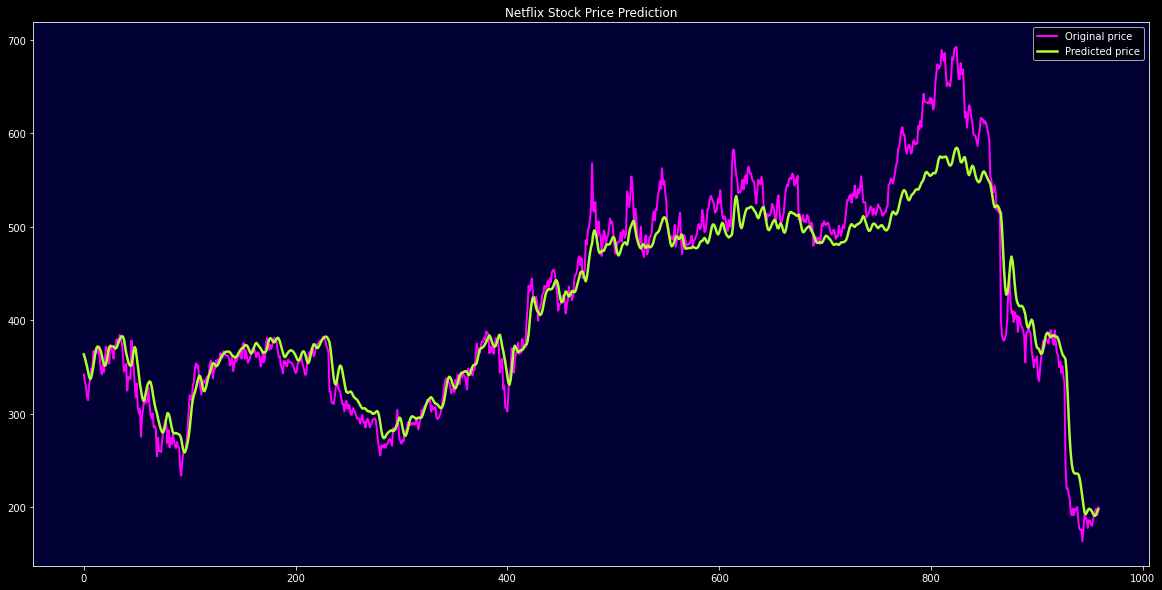

In [179]:
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(20,10))
ax.set_facecolor('#000035')
ax.plot(y_test_scaled, color='fuchsia', linewidth=2, label='Original price')
plt.plot(predictions, color='greenyellow', linewidth=2.5, label='Predicted price')
plt.title('Netflix Stock Price Prediction')
plt.legend(); 

### 👍 If you find this notebook useful, please support with an upvote 👍